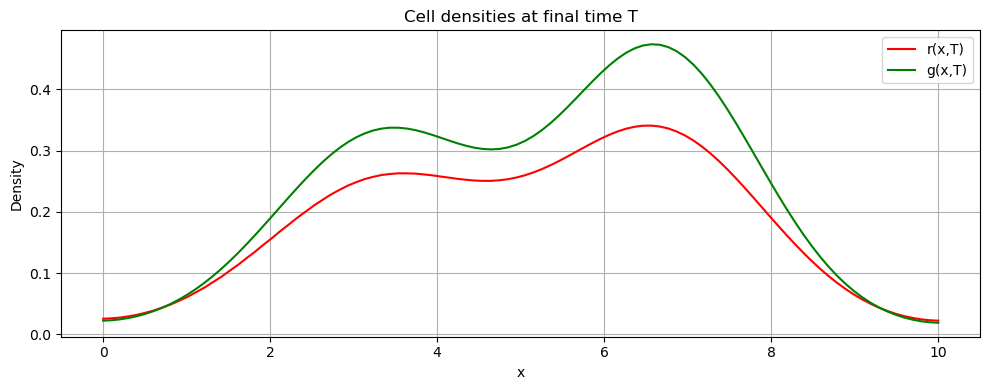

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

L = 10.0        # Domain length
Nx = 100        # Number of spatial points
T = 10.0        # Final time
D1 = 0.1        # Diffusion coefficient for r
D2 = 0.05       # Diffusion coefficient for g
k1 = 0.2        # Transition rate from G1 to G2
k2 = 0.1        # Mitosis rate of G2

x = np.linspace(0, L, Nx)
dx = x[1] - x[0]

def initial_conditions(x):
    r0 = np.exp(-((x - L/3) ** 2) / 0.5)
    g0 = np.exp(-((x - 2*L/3) ** 2) / 0.5)
    return r0, g0

def laplacian(u, dx):
    dudx2 = np.zeros_like(u)
    dudx2[1:-1] = (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2
    dudx2[0] = (u[1] - u[0]) / dx**2         # Forward difference at left boundary
    dudx2[-1] = (u[-2] - u[-1]) / dx**2      # Backward difference at right boundary
    return dudx2

def rhs(t, y):
    r = y[:Nx]
    g = y[Nx:]

    drdt = D1 * laplacian(r, dx) - k1 * r + 2 * k2 * g
    dgdt = D2 * laplacian(g, dx) + k1 * r - k2 * g

    return np.concatenate([drdt, dgdt])

r0, g0 = initial_conditions(x)
y0 = np.concatenate([r0, g0])

solution = solve_ivp(rhs, [0, T], y0, t_eval=np.linspace(0, T, 200), method='RK45')

R = solution.y[:Nx, :]
G = solution.y[Nx:, :]

# plot at final time
plt.figure(figsize=(10, 4))
plt.plot(x, R[:, -1], label='r(x,T)', color='red')
plt.plot(x, G[:, -1], label='g(x,T)', color='green')
plt.title("Cell densities at final time T")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


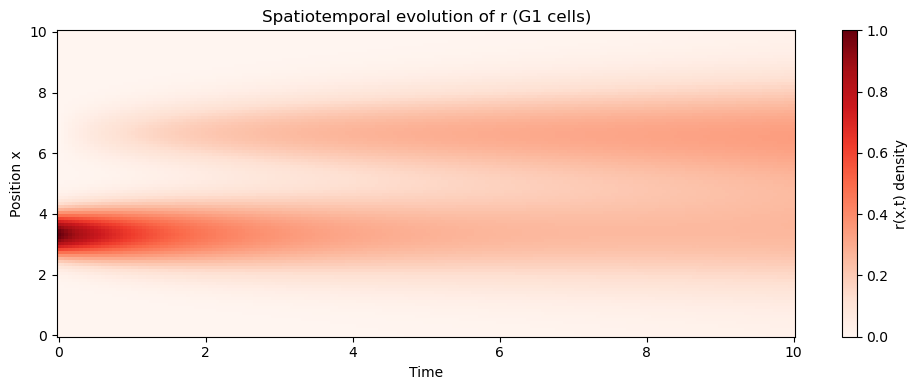

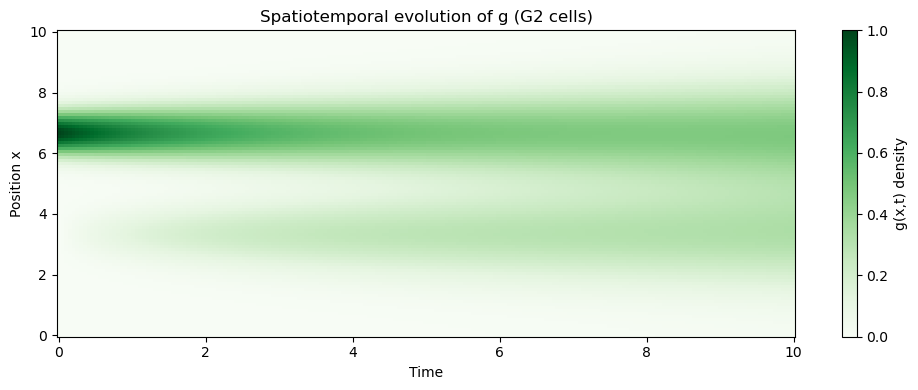

In [3]:
from matplotlib import cm

# Create time and space grids for plotting
t = solution.t  # time vector already used in solve_ivp

# Plot heatmap for r(x, t)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, x, R, shading='auto', cmap='Reds')
plt.colorbar(label='r(x,t) density')
plt.xlabel('Time')
plt.ylabel('Position x')
plt.title('Spatiotemporal evolution of r (G1 cells)')
plt.tight_layout()
plt.show()

# Plot heatmap for g(x, t)
plt.figure(figsize=(10, 4))
plt.pcolormesh(t, x, G, shading='auto', cmap='Greens')
plt.colorbar(label='g(x,t) density')
plt.xlabel('Time')
plt.ylabel('Position x')
plt.title('Spatiotemporal evolution of g (G2 cells)')
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# --------------------------
# Model parameters (true values)
# --------------------------
D1_true = 0.1
D2_true = 0.05
k1_true = 0.2
k2_true = 0.1
true_params = [D1_true, D2_true, k1_true, k2_true]

# --------------------------
# Discretization (reduced)
# --------------------------
L = 1.0
Nx = 50              # Reduced from 100
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
T = 10.0
Nt = 100             # Reduced from 200
t_eval = np.linspace(0, T, Nt)

# --------------------------
# Initial conditions
# --------------------------
r0 = np.exp(-50 * (x - 0.3)**2)
g0 = np.exp(-50 * (x - 0.7)**2)
y0 = np.concatenate([r0, g0])

# --------------------------
# Laplacian (Neumann BC)
# --------------------------
def laplacian(u, dx):
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[:-2] - 2*u[1:-1] + u[2:]) / dx**2
    u_xx[0] = (u[1] - u[0]) / dx**2
    u_xx[-1] = (u[-2] - u[-1]) / dx**2
    return u_xx

# --------------------------
# RHS of PDE system
# --------------------------
def rhs(t, y, D1, D2, k1, k2):
    r = y[:Nx]
    g = y[Nx:]
    drdt = D1 * laplacian(r, dx) - k1 * r + 2 * k2 * g
    dgdt = D2 * laplacian(g, dx) + k1 * r - k2 * g
    return np.concatenate([drdt, dgdt])

# --------------------------
# Simulate with true parameters
# --------------------------
sol = solve_ivp(lambda t, y: rhs(t, y, *true_params),
                [0, T], y0, t_eval=t_eval, method='LSODA')

r_true = sol.y[:Nx, :]
g_true = sol.y[Nx:, :]

# --------------------------
# Add log-normal noise
# --------------------------
rng = np.random.default_rng(42)
noise_std = 0.05
r_obs = r_true * np.exp(noise_std * rng.standard_normal(r_true.shape))
g_obs = g_true * np.exp(noise_std * rng.standard_normal(g_true.shape))

# --------------------------
# Fast & stable cost function
# --------------------------
def cost_function(params):
    D1, D2, k1, k2 = params
    try:
        sol = solve_ivp(lambda t, y: rhs(t, y, D1, D2, k1, k2),
                        [0, T], y0, t_eval=t_eval, method='LSODA')
        if not sol.success or np.any(np.isnan(sol.y)):
            return np.inf
        r_sim = sol.y[:Nx, :]
        g_sim = sol.y[Nx:, :]
    except Exception:
        return np.inf

    eps = 1e-8
    log_r_sim = np.log(np.clip(r_sim, eps, None))
    log_g_sim = np.log(np.clip(g_sim, eps, None))
    log_r_obs = np.log(np.clip(r_obs, eps, None))
    log_g_obs = np.log(np.clip(g_obs, eps, None))

    return np.mean((log_r_sim - log_r_obs)**2 + (log_g_sim - log_g_obs)**2)

# --------------------------
# Parameter estimation
# --------------------------
initial_guess = [0.08, 0.04, 0.15, 0.12]
bounds = [(1e-4, 1), (1e-4, 1), (1e-3, 1), (1e-3, 1)]

result = minimize(cost_function, initial_guess, bounds=bounds,
                  method='L-BFGS-B', options={'maxiter': 50})  # limit iterations

# --------------------------
# Results
# --------------------------
print("True parameters:      ", true_params)
print("Estimated parameters: ", result.x)
print("Optimization success: ", result.success)
print("Final cost:           ", result.fun)


True parameters:       [0.1, 0.05, 0.2, 0.1]
Estimated parameters:  [0.10119242 0.0503409  0.19991737 0.09971786]
Optimization success:  True
Final cost:            0.005052696378762346


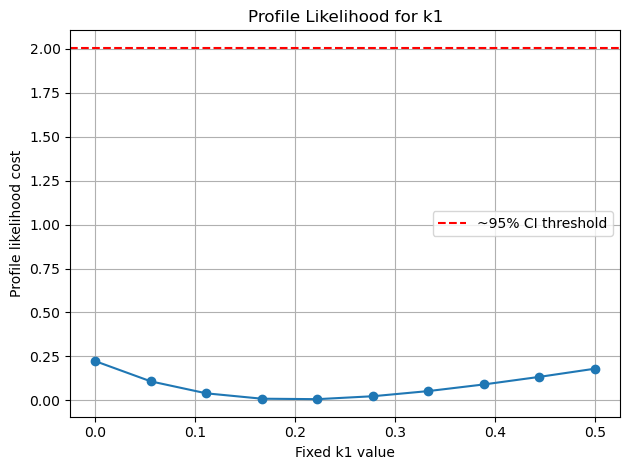

In [31]:
# --------------------------
# Profile Likelihood for k1
# --------------------------
k1_vals = np.linspace(0.0, 0.5, 10)
profile_costs = []

for k1_fixed in k1_vals:
    def profile_cost(p):
        D1, D2, k2 = p
        return cost_function([D1, D2, k1_fixed, k2])

    # Use result.x as a warm start (excluding k1)
    p0 = [result.x[0], result.x[1], result.x[3]]
    bnds = [bounds[0], bounds[1], bounds[3]]

    res = minimize(profile_cost, p0, bounds=bnds, method='L-BFGS-B',
                   options={'maxiter': 30})  # faster

    profile_costs.append(res.fun)

# Plot
plt.plot(k1_vals, profile_costs, marker='o')
plt.axhline(result.fun + 2, color='red', linestyle='--', label='~95% CI threshold')
plt.xlabel('Fixed k1 value')
plt.ylabel('Profile likelihood cost')
plt.title('Profile Likelihood for k1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# --------------------------
# Model parameters (true values)
# --------------------------
D1_true = 0.1
D2_true = 0.05
k1_true = 0.2
k2_true = 0.1
true_params = [D1_true, D2_true, k1_true, k2_true]

# --------------------------
# Discretization (reduced)
# --------------------------
L = 1.0
Nx = 50
x = np.linspace(0, L, Nx)
dx = x[1] - x[0]
T = 10.0
Nt = 100
t_eval = np.linspace(0, T, Nt)

# --------------------------
# Initial conditions
# --------------------------
r0 = np.exp(-50 * (x - 0.3)**2)
g0 = np.exp(-50 * (x - 0.7)**2)
y0 = np.concatenate([r0, g0])

# --------------------------
# Laplacian (Neumann BC)
# --------------------------
def laplacian(u, dx):
    u_xx = np.zeros_like(u)
    u_xx[1:-1] = (u[:-2] - 2*u[1:-1] + u[2:]) / dx**2
    u_xx[0] = (u[1] - u[0]) / dx**2
    u_xx[-1] = (u[-2] - u[-1]) / dx**2
    return u_xx

# --------------------------
# RHS of PDE system
# --------------------------
def rhs(t, y, D1, D2, k1, k2):
    r = y[:Nx]
    g = y[Nx:]
    drdt = D1 * laplacian(r, dx) - k1 * r + 2 * k2 * g
    dgdt = D2 * laplacian(g, dx) + k1 * r - k2 * g
    return np.concatenate([drdt, dgdt])

# --------------------------
# Simulate with true parameters
# --------------------------
sol = solve_ivp(lambda t, y: rhs(t, y, *true_params),
                [0, T], y0, t_eval=t_eval, method='LSODA')

r_true = sol.y[:Nx, :]
g_true = sol.y[Nx:, :]

# --------------------------
# Add log-normal noise
# --------------------------
rng = np.random.default_rng(42)
noise_std = 0.05
r_obs = r_true * np.exp(noise_std * rng.standard_normal(r_true.shape))
g_obs = g_true * np.exp(noise_std * rng.standard_normal(g_true.shape))

# --------------------------
# Proper Negative Log-Likelihood cost function (log-normal noise)
# --------------------------
def cost_function(params):
    D1, D2, k1, k2 = params
    try:
        sol = solve_ivp(lambda t, y: rhs(t, y, D1, D2, k1, k2),
                        [0, T], y0, t_eval=t_eval, method='LSODA')
        if not sol.success or np.any(np.isnan(sol.y)):
            return np.inf
        r_sim = sol.y[:Nx, :]
        g_sim = sol.y[Nx:, :]
    except Exception:
        return np.inf

    eps = 1e-8
    log_r_sim = np.log(np.clip(r_sim, eps, None))
    log_g_sim = np.log(np.clip(g_sim, eps, None))
    log_r_obs = np.log(np.clip(r_obs, eps, None))
    log_g_obs = np.log(np.clip(g_obs, eps, None))

    sigma2 = noise_std**2
    nll_r = 0.5 * np.sum((log_r_obs - log_r_sim)**2) / sigma2
    nll_g = 0.5 * np.sum((log_g_obs - log_g_sim)**2) / sigma2

    return nll_r + nll_g

# --------------------------
# Parameter estimation
# --------------------------
initial_guess = [0.08, 0.04, 0.15, 0.12]
bounds = [(1e-4, 1), (1e-4, 1), (1e-3, 1), (1e-3, 1)]

result = minimize(cost_function, initial_guess, bounds=bounds,
                  method='L-BFGS-B', options={'maxiter': 50})

# --------------------------
# Results
# --------------------------
print("True parameters:      ", true_params)
print("Estimated parameters: ", result.x)
print("Optimization success: ", result.success)
print("Final NLL cost:       ", result.fun)


True parameters:       [0.1, 0.05, 0.2, 0.1]
Estimated parameters:  [0.10119165 0.05034019 0.19991544 0.09971761]
Optimization success:  True
Final NLL cost:        5052.696348826918


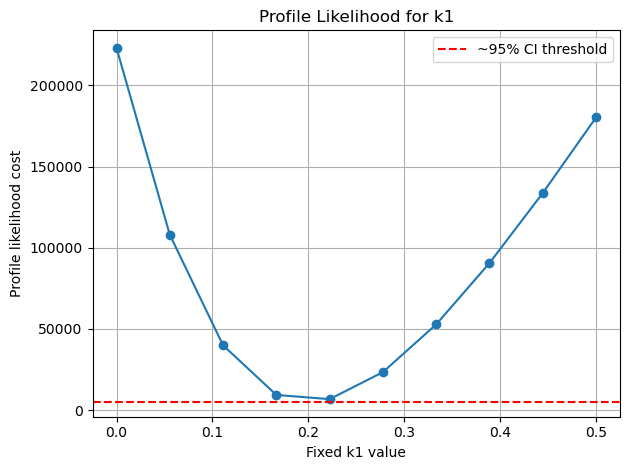

In [34]:
# --------------------------
# Profile Likelihood for k1
# --------------------------
k1_vals = np.linspace(0.0, 0.5, 10)
profile_costs = []

for k1_fixed in k1_vals:
    def profile_cost(p):
        D1, D2, k2 = p
        return cost_function([D1, D2, k1_fixed, k2])

    # Use result.x as a warm start (excluding k1)
    p0 = [result.x[0], result.x[1], result.x[3]]
    bnds = [bounds[0], bounds[1], bounds[3]]

    res = minimize(profile_cost, p0, bounds=bnds, method='L-BFGS-B',
                   options={'maxiter': 30})  # faster

    profile_costs.append(res.fun)

# Plot
plt.plot(k1_vals, profile_costs, marker='o')
plt.axhline(result.fun + 2, color='red', linestyle='--', label='~95% CI threshold')
plt.xlabel('Fixed k1 value')
plt.ylabel('Profile likelihood cost')
plt.title('Profile Likelihood for k1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


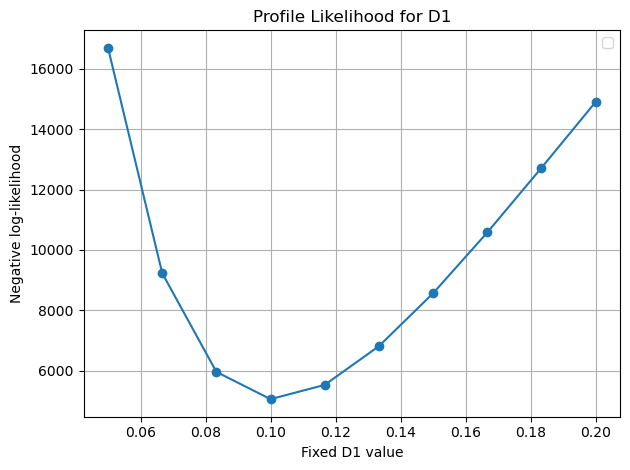

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


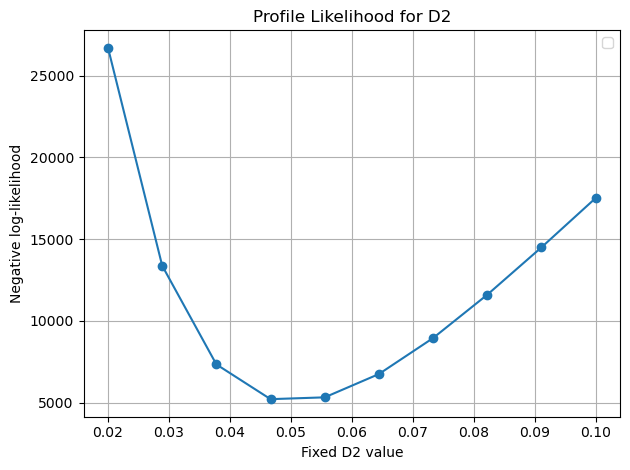

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


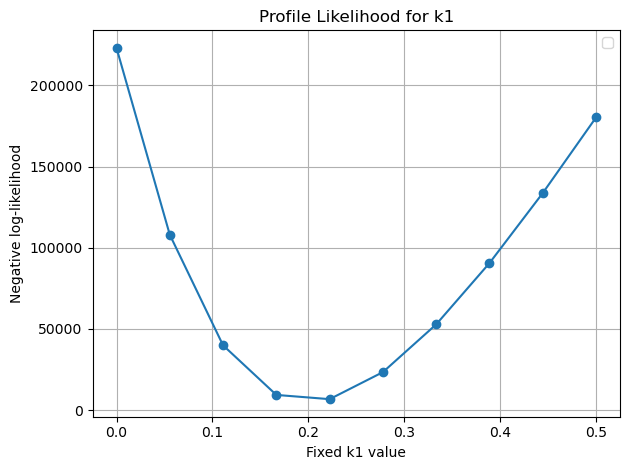

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


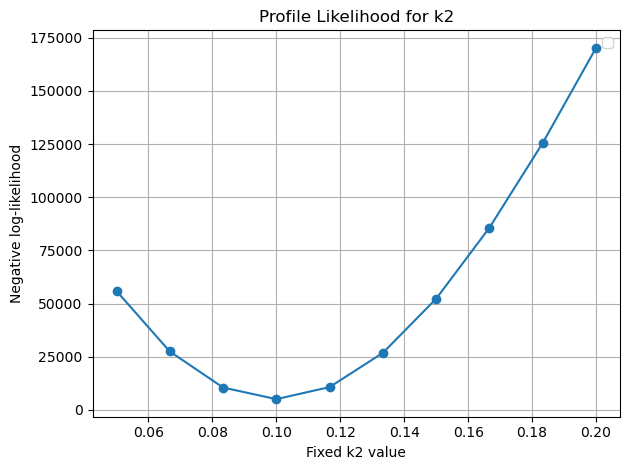

In [39]:
import matplotlib.pyplot as plt

# Define fixed value ranges
param_ranges = {
    'D1': np.linspace(0.05, 0.2, 10),
    'D2': np.linspace(0.02, 0.1, 10),
    'k1': np.linspace(0.0, 0.5, 10),
    'k2': np.linspace(0.05, 0.2, 10)
}

# Function to compute profile likelihood for a single parameter
def compute_profile(param_name, fixed_vals, fixed_idx):
    profile_vals = []

    for val in fixed_vals:
        def profile_cost(p):
            full_param = list(p)
            full_param.insert(fixed_idx, val)
            return cost_function(full_param)

        # Drop the fixed parameter from initial guess and bounds
        p0 = [p for i, p in enumerate(result.x) if i != fixed_idx]
        bnds = [b for i, b in enumerate(bounds) if i != fixed_idx]

        res = minimize(profile_cost, p0, bounds=bnds, method='L-BFGS-B',
                       options={'maxiter': 30})
        profile_vals.append(res.fun)

    return profile_vals

# Compute and plot for each parameter
for i, param in enumerate(['D1', 'D2', 'k1', 'k2']):
    fixed_vals = param_ranges[param]
    profile = compute_profile(param, fixed_vals, i)

    plt.figure()
    plt.plot(fixed_vals, profile, marker='o')
   #plt.axhline(result.fun + 2, color='red', linestyle='--', label='~95% CI threshold')
    plt.xlabel(f'Fixed {param} value')
    plt.ylabel('Negative log-likelihood')
    plt.title(f'Profile Likelihood for {param}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Attempts to deal with f+g

In [6]:
def rhs(t, y, D1, D2, k1, k2):
    r = y[:Nx]
    g = y[Nx:]
    drdt = D1 * laplacian(r, dx) - k1 * r + 2 * k2 * g
    dgdt = D2 * laplacian(g, dx) + k1 * r - k2 * g
    return np.concatenate([drdt, dgdt])

In [3]:
sol = solve_ivp(lambda t, y: rhs(t, y, *true_params),
                [0, T], y0, t_eval=t_eval, method='LSODA')

r_true = sol.y[:Nx, :]
g_true = sol.y[Nx:, :]

rho_true = r_true+ g_true

# noise
sigma = 0.05
noise = np.random.normal(0, sigma, rho_true.shape)
rho_obs = rho_true + noise

In [8]:
def objective(params):
    D, k_r, k_g = params
    sol = solve_ivp(lambda t, y: rhs(t, y, D, D, k_r, k_g),
                    [0, T], y0, t_eval=t_eval, method='LSODA')
    r = sol.y[:Nx, :]
    g = sol.y[Nx:, :]
    rho_sim = r + g
    return np.sum((rho_sim - rho_obs)**2)

from scipy.optimize import minimize

initial_guess = [0.2, 1.0, 1.0]
bounds = [(0.01, 1.0), (0.1, 5.0), (0.1, 5.0)]

result = minimize(objective, initial_guess, bounds=bounds)
print("Estimated parameters:", result.x)
print(f"Estimated parameters:\n  D  = {result.x[0]:.6f}\n  k1 = {result.x[1]:.6f}\n  k2 = {result.x[2]:.6f}")




Estimated parameters: [0.05641336 0.13724861 0.1169699 ]
Estimated parameters:
  D  = 0.056413
  k1 = 0.137249
  k2 = 0.116970


In [9]:
D1_true = 0.1
D2_true = 0.05
k1_true = 0.2
k2_true = 0.1
true_params = [D1_true, D2_true, k1_true, k2_true]
